In [2]:
# import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from implementations import *
# import SVM

### Prepare the data ###

Procedure: 1. normalize coding for missing values: check each feature, assign NaN to values > 95% percentile. --> 2. check each row, drop the rows where over 50% of the features are NaN. Also remove the corresponding y  --> 3. Check each columns, drop the feature where over 50% of the rows are NaN or std == 0. Record the index for test set. --> 4. Handling NaN values: check for categorical feature (record the index), assign NaN to mean for non-categorical and majority label for categorial. --> 5. One-hot encoding for categorical data. --> 6. Standardize (skip categorical 0-1 columns)  --> 7. Regard a datapoint having more than 30% of the features with Z-score>2.5 as outliers, remove from x and corresponding y. --> 8. Data Augmentation --> 9. PCA 

In [3]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("./data/dataset_to_release", sub_sample=True)

In [3]:
print(x_train.shape)
print(y_train.shape)

(6563, 321)
(6563,)


In [9]:
x_sub, y_sub = split_cross_validation(x_train, y_train, 10)
np.shape(x_sub[0])

(656, 321)

In [4]:
# thresholds for nans
row_nan = 0.55
feature_nan = 0.8
# threshold for categorical features
threshold_cat = 10
# threshold for outliers
z_threshold=2
feature_threshold=0.15

x_train_processed = x_train.copy()
y_train_processed = y_train.copy()

# transform y to 0-1 encoding
y_train_processed = process_y(y_train_processed)

# Uniform missing value encoding
x_train_processed = normalize_nan(x_train_processed)
# Remove rows with too many nans
x_train_processed, y_train_processed = drop_rows(x_train_processed, y_train_processed, row_nan) # 0.55 remains 6101 rows
# x_train_processed.shape
# Remove features with too many nans
x_train_processed, nan_indices = drop_features(x_train_processed, feature_nan) # 0.5 remains 174 features
print(x_train_processed.shape)

# get categorical feature indices
cat_indices = check_categorical(x_train_processed, threshold_cat)
# handling remaining nans
x_train_processed = fillna(x_train_processed, cat_indices)
# One hot encoding for categorical features
x_train_processed = one_hot_encoding(x_train_processed, cat_indices)
x_train_processed = standardize(x_train_processed)
x_train_processed, y_train_processed = z_outlier_removal(x_train_processed, y_train_processed, z_threshold, feature_threshold)
x_train_processed.shape
# x_train_processed = add_bias(x_train_processed)


(6101, 199)


(6101, 521)

In [5]:
np.sum(y_train_processed==1)

536

In [6]:
print(x_train_processed.shape)
print(y_train_processed.shape)
print(np.sum(x_train_processed.std(axis=0) == 0))

(6093, 446)
(6093,)
0


In [7]:
# x_train_processed_orig = x_train.copy()
# x_train_processed_orig = fillna_with_mean(x_train_processed_orig, threshold=threshold_nan)
# x_train_processed_orig = standardize(x_train_processed_orig)
# x_train_processed_orig = polynomial_expansion_single(x_train_processed_orig, degree=2)
# x_train_processed_orig = standardize(x_train_processed_orig)
# x_train_processed_orig = add_bias(x_train_processed_orig)
# # add a column of ones
# y_train_processed_orig = y_train.copy()
# y_train_processed_orig = process_y(y_train_processed_orig)
# print(np.isnan(x_train_processed_orig).any())

In [8]:
# print(x_train_processed_orig.shape)
# print(y_train_processed_orig.shape)

In [9]:
## PCA feature selection 
pre_train_data = x_train_processed.copy()

x_pca, eig_vec, eig_val,weight = pca(pre_train_data, 200)
print(weight)

[ 5.26568829e-02+3.28389692e-36j  4.02483804e-02+2.51005234e-36j
  3.03924838e-02+1.89539863e-36j  2.49265648e-02+1.55452174e-36j
  2.18695115e-02+1.36387149e-36j  1.94795027e-02+1.21482084e-36j
  1.73995382e-02+1.08510582e-36j  1.65357118e-02+1.03123410e-36j
  1.56929782e-02+9.78677806e-37j  1.44867255e-02+9.03450997e-37j
  1.37198643e-02+8.55626416e-37j  1.33676614e-02+8.33661616e-37j
  1.28341179e-02+8.00387676e-37j  1.22195935e-02+7.62063440e-37j
  1.16619885e-02+7.27288931e-37j  1.14594041e-02+7.14654948e-37j
  1.12799034e-02+7.03460551e-37j  1.04455630e-02+6.51427698e-37j
  9.91533879e-03+6.18360767e-37j  9.08010631e-03+5.66272280e-37j
  8.87686340e-03+5.53597227e-37j  8.66614304e-03+5.40455850e-37j
  8.41713465e-03+5.24926676e-37j  7.99141873e-03+4.98377304e-37j
  7.94743009e-03+4.95633994e-37j  7.71911948e-03+4.81395618e-37j
  7.54541672e-03+4.70562809e-37j  7.36794659e-03+4.59495051e-37j
  7.27105948e-03+4.53452778e-37j  6.96238106e-03+4.34202339e-37j
  6.83296695e-03+4.261315

In [10]:
x_pca.shape

(6093, 200)

/home/ivonne/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


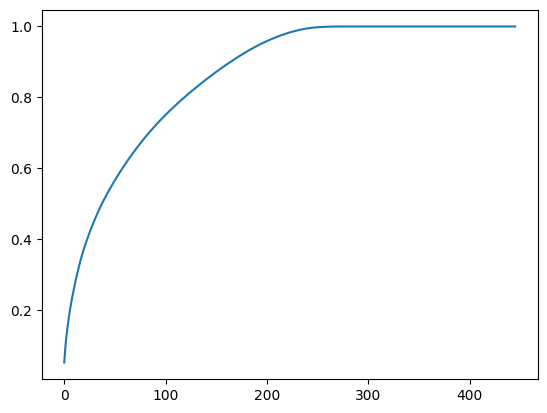

In [11]:
cummulation = np.cumsum(weight)
cummulation
plt.plot(cummulation)

In [12]:
x_pca.shape

(6093, 200)

### Experiment ###

In [7]:
## linear regression using all the features except for those having NaN values over 50% ##
x_t, y_t, x_v, y_v = split_data(add_bias(x_train_processed), y_train_processed, 0.9)
# x_t, y_t = data_augmentation(x_t, y_t)
initial_w = np.random.randn(x_t.shape[1]) * 0.01
w, loss = mean_square_error_gd(y_t, x_t, initial_w, max_iters=500, gamma=0.01)
y_pred = x_v @ w
y_pred_mean = np.mean(y_pred)
y_pred = (y_pred > y_pred_mean).astype(int)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)

GD iter. 0/499: loss=0.06394634915180893
GD iter. 10/499: loss=0.03961391798968512
GD iter. 20/499: loss=0.038320730961004426
GD iter. 30/499: loss=0.037499733991507335
GD iter. 40/499: loss=0.036915451129429094
GD iter. 50/499: loss=0.03647201929627528
GD iter. 60/499: loss=0.036120910228329375
GD iter. 70/499: loss=0.03583407179388655
GD iter. 80/499: loss=0.03559397625899747
GD iter. 90/499: loss=0.03538908101728824
GD iter. 100/499: loss=0.03521146274871529
GD iter. 110/499: loss=0.03505548636346044
GD iter. 120/499: loss=0.03491701924052287
GD iter. 130/499: loss=0.034792949896194726
GD iter. 140/499: loss=0.03468088312000202
GD iter. 150/499: loss=0.034578940554541256
GD iter. 160/499: loss=0.03448562612025759
GD iter. 170/499: loss=0.03439973249642951
GD iter. 180/499: loss=0.034320274375879485
GD iter. 190/499: loss=0.03424643969606625
GD iter. 200/499: loss=0.03417755327930504
GD iter. 210/499: loss=0.034113049259400195
GD iter. 220/499: loss=0.03405244987111798
GD iter. 230/4

0.27672955974842767

In [14]:
x_train_processed.shape

(6093, 446)

In [27]:
# logistic regression using all the features except for those having NaN values over 50% ##
x_t, y_t, x_v, y_v = split_data(add_bias(x_train_processed), y_train_processed, 0.9)
x_t, y_t = data_augmentation(x_t, y_t)
initial_w = np.random.randn(x_t.shape[1]) * 0.01
w, loss = logistic_regression(y_t, x_t, initial_w, max_iters=500, gamma=0.1)
y_pred = sigmoid(x_v @ w)
y_pred = (y_pred >= 0.7).astype(int)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)

GD iter. 0/499: loss=0.7077207253086517
GD iter. 1/499: loss=0.5504003964501993
GD iter. 2/499: loss=0.5328991040001598
GD iter. 3/499: loss=0.523618274201921
GD iter. 4/499: loss=0.5169128907141344
GD iter. 5/499: loss=0.5114694869024743
GD iter. 6/499: loss=0.5068135380469915
GD iter. 7/499: loss=0.5027148388779595
GD iter. 8/499: loss=0.49903750717093687
GD iter. 9/499: loss=0.49569148737380253
GD iter. 10/499: loss=0.4926130762662449
GD iter. 11/499: loss=0.4897554310139592
GD iter. 12/499: loss=0.48708319660399824
GD iter. 13/499: loss=0.4845691488492277
GD iter. 14/499: loss=0.4821919660195744
GD iter. 15/499: loss=0.47993469317199294
GD iter. 16/499: loss=0.47778365692880004
GD iter. 17/499: loss=0.4757276841343601
GD iter. 18/499: loss=0.47375753070307736
GD iter. 19/499: loss=0.4718654585931703
GD iter. 20/499: loss=0.4700449187563622
GD iter. 21/499: loss=0.4682903108985622
GD iter. 22/499: loss=0.4665967995626002
GD iter. 23/499: loss=0.46496017195032163
GD iter. 24/499: los

0.3356643356643356

In [28]:
# logistic regression
x_t, y_t, x_v, y_v = split_data(add_bias(x_train_processed), y_train_processed, 0.9)
x_t, y_t = data_augmentation(x_t, y_t)
initial_w = np.random.randn(x_t.shape[1]) * 0.01
w, loss = reg_logistic_regression(y_t, x_t, lambda_=0.1, initial_w=initial_w, max_iters=500, gamma=0.15)
y_pred = (x_v @ w >= 0.75).astype(int)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)

GD iter. 0/499: loss=0.6841652468260004
GD iter. 1/499: loss=0.537219050339916
GD iter. 2/499: loss=0.5245618808876236
GD iter. 3/499: loss=0.516075298782938
GD iter. 4/499: loss=0.5095856970366582
GD iter. 5/499: loss=0.5043150077699387
GD iter. 6/499: loss=0.49987862532614075
GD iter. 7/499: loss=0.4960497151284852
GD iter. 8/499: loss=0.4926841566476931
GD iter. 9/499: loss=0.4896856679653233
GD iter. 10/499: loss=0.4869869961749231
GD iter. 11/499: loss=0.4845392200872446
GD iter. 12/499: loss=0.4823054525791568
GD iter. 13/499: loss=0.48025700842599084
GD iter. 14/499: loss=0.478370992728854
GD iter. 15/499: loss=0.47662873164397923
GD iter. 16/499: loss=0.4750147175076968
GD iter. 17/499: loss=0.4735158776149945
GD iter. 18/499: loss=0.4721210527320731
GD iter. 19/499: loss=0.4708206154638343
GD iter. 20/499: loss=0.46960618445396396
GD iter. 21/499: loss=0.4684704059456871
GD iter. 22/499: loss=0.46740678381145956
GD iter. 23/499: loss=0.4664095452053542
GD iter. 24/499: loss=0.

0.3780487804878049

In [17]:
# ridge regression using all the features except for those having NaN values over 50% ##
x_t, y_t, x_v, y_v = split_data(add_bias(x_train_processed), y_train_processed, 0.9)
x_t, y_t = data_augmentation(x_t, y_t)
w, loss = ridge_regression(y_t, x_t, lambda_=0.01)
y_pred = x_v @ w
y_pred_mean = np.mean(y_pred)
y_pred = (y_pred > y_pred_mean).astype(int)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)

The Accuracy is: 0.5689
The F1 score is: 0.2102
The precision is: 0.1199
The recall is: 0.8537


0.21021021021021016

#### Hinge loss gradient descent

In [18]:
accs = []
f1 = []
for i in range(10):
    x_t, y_t, x_v, y_v = split_data(x_train_processed, y_train_processed, 0.9)
    x_t, y_t = data_augmentation(x_t, y_t)
    initial_w = np.random.randn(x_t.shape[1]) * 0.01
    w, loss = hinge_regression(y_t, x_t, initial_w, lambda_=0.1, max_iters=500, gamma=0.01)
    y_pred = ((x_v @ w) > 0.5).astype(int)
    accs.append(predict_acc_pure(y_pred, y_v))
    f1.append(predict_f1_pure(y_pred, y_v))
print("Final accuracy score is: ", np.mean(accs))
print("Final f1 score is: ", np.mean(f1))

GD iter. 0/499: loss=0.9913199633809331
GD iter. 1/499: loss=0.9185902320125032
GD iter. 2/499: loss=0.8469167125992535
GD iter. 3/499: loss=0.78115290905863
GD iter. 4/499: loss=0.7333532552998508
GD iter. 5/499: loss=0.7027635757220305
GD iter. 6/499: loss=0.6827822935647762
GD iter. 7/499: loss=0.6681868370607503
GD iter. 8/499: loss=0.657830379761844
GD iter. 9/499: loss=0.649922603159183
GD iter. 10/499: loss=0.6438108473792942
GD iter. 11/499: loss=0.6391750940974552
GD iter. 12/499: loss=0.6350487492049526
GD iter. 13/499: loss=0.6313398496896179
GD iter. 14/499: loss=0.6280449431716127
GD iter. 15/499: loss=0.6251846357292073
GD iter. 16/499: loss=0.6226585387470225
GD iter. 17/499: loss=0.6202739167661988
GD iter. 18/499: loss=0.6181038873375189
GD iter. 19/499: loss=0.6162564825106277
GD iter. 20/499: loss=0.614491281985601
GD iter. 21/499: loss=0.6128041252038765
GD iter. 22/499: loss=0.6112090388333594
GD iter. 23/499: loss=0.6096361163330936
GD iter. 24/499: loss=0.6081419

In [19]:
import sklearn.svm as svm
cls = svm.SVC(C=50, kernel='rbf')
x_t, y_t, x_v, y_v = split_data(x_train_processed_hinge, y_train_processed_hinge, 0.9)
cls.fit(x_t, y_t)
y_pred = cls.predict(x_v)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)

ModuleNotFoundError: No module named 'sklearn'

#### PCA

In [ ]:
## linear regression using PCA feature selection ##
x_pca_t = add_bias(x_pca)
x_t, y_t, x_v, y_v = split_data(x_pca_t, y_train_processed, 0.9)
# x_t, y_t = data_augmentation(x_t, y_t)
initial_w = np.random.randn(x_pca_t.shape[1]) * 0.01
w, loss = mean_square_error_gd(y_t, x_t, initial_w, max_iters = 500, gamma=0.05)
y_pred = x_v @ w
y_pred_mean = np.mean(y_pred)
y_pred = (y_pred >= y_pred_mean).astype(int)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)

GD iter. 0/499: loss=(0.0635121239387749+0j)
GD iter. 10/499: loss=(0.03499360164250566+0j)
GD iter. 20/499: loss=(0.032219675441975+0j)
GD iter. 30/499: loss=(0.03140766729669545+0j)
GD iter. 40/499: loss=(0.031123605529602+0j)
GD iter. 50/499: loss=(0.031015348713709905+0j)
GD iter. 60/499: loss=(0.030971639066752436+0j)
GD iter. 70/499: loss=(0.030953165467271105+0j)
GD iter. 80/499: loss=(0.030945049333066486+0j)
GD iter. 90/499: loss=(0.03094136228476214+0j)
GD iter. 100/499: loss=(0.03093963843538125+0j)
GD iter. 110/499: loss=(0.030938812584707584+0j)
GD iter. 120/499: loss=(0.03093840882467128+0j)
GD iter. 130/499: loss=(0.03093820810333348+0j)
GD iter. 140/499: loss=(0.030938106954342837+0j)
GD iter. 150/499: loss=(0.030938055419327343+0j)
GD iter. 160/499: loss=(0.030938028928111847+0j)
GD iter. 170/499: loss=(0.03093801521202983+0j)
GD iter. 180/499: loss=(0.030938008068529962+0j)
GD iter. 190/499: loss=(0.030938004330064186+0j)
GD iter. 200/499: loss=(0.030938002365689204+0

In [ ]:
# logistic regression using pca feature selection #
x_pca_t = add_bias(x_pca)
x_t, y_t, x_v, y_v = split_data(x_pca_t, y_train_processed, 0.9)
x_t, y_t = data_augmentation(x_t, y_t)
initial_w = np.random.randn(x_pca_t.shape[1]) * 0.01
w, loss = logistic_regression(y_t, x_t, initial_w, max_iters=500, gamma=0.15)
y_pred = sigmoid(x_v @ w)
y_pred = (y_pred >= 0.7).astype(int)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)

GD iter. 0/499: loss=(0.7234766967337769-0j)
GD iter. 1/499: loss=(0.5451834908591477-0j)
GD iter. 2/499: loss=(0.5331040872150704-0j)
GD iter. 3/499: loss=(0.5245318812979132-0j)
GD iter. 4/499: loss=(0.5178091084500906-0j)
GD iter. 5/499: loss=(0.5122486033535671-0j)
GD iter. 6/499: loss=(0.5074821286021316-0j)
GD iter. 7/499: loss=(0.503287997796-0j)
GD iter. 8/499: loss=(0.49952450604815485-0j)
GD iter. 9/499: loss=(0.49609732064821677-0j)
GD iter. 10/499: loss=(0.49294145895859404-0j)
GD iter. 11/499: loss=(0.490010707989586-0j)
GD iter. 12/499: loss=(0.4872711863187253-0j)
GD iter. 13/499: loss=(0.48469732175691993-0j)
GD iter. 14/499: loss=(0.4822692806145236-0j)
GD iter. 15/499: loss=(0.4799712896441396-0j)
GD iter. 16/499: loss=(0.47779051811692536-0j)
GD iter. 17/499: loss=(0.4757163179741322-0j)
GD iter. 18/499: loss=(0.47373969698073787-0j)
GD iter. 19/499: loss=(0.4718529461275023-0j)
GD iter. 20/499: loss=(0.47004937088923326-0j)
GD iter. 21/499: loss=(0.4683230935948921-

In [ ]:
# logistic regression using pca feature selection #
initial_w = np.random.randn(x_pca.shape[1]) * 0.01
w, loss = reg_logistic_regression(y_train_processed, x_pca, lambda_=0.01, initial_w=initial_w, max_iters=100, gamma=0.15)
predict_acc(x_train_processed_orig_pca, y_train_processed_orig, w, logistic=False, threshold=0.85)
predict_f1(x_train_processed_orig_pca, y_train_processed_orig, w, logistic=False, threshold=0.85)

GD iter. 0/99: loss=(0.6909626798061412-0j)
GD iter. 1/99: loss=(0.6735794558601624-0j)
GD iter. 2/99: loss=(0.6583223113486754-0j)
GD iter. 3/99: loss=(0.6448689264505854-0j)
GD iter. 4/99: loss=(0.6329464838761912-0j)
GD iter. 5/99: loss=(0.6223263407459684-0j)
GD iter. 6/99: loss=(0.6128178374165825-0j)
GD iter. 7/99: loss=(0.6042622492063763-0j)
GD iter. 8/99: loss=(0.5965273504120941-0j)
GD iter. 9/99: loss=(0.5895027471942651-0j)
GD iter. 10/99: loss=(0.5830959752063374-0j)
GD iter. 11/99: loss=(0.5772292865389332-0j)
GD iter. 12/99: loss=(0.5718370269939669-0j)
GD iter. 13/99: loss=(0.566863504476215-0j)
GD iter. 14/99: loss=(0.5622612591162924-0j)
GD iter. 15/99: loss=(0.5579896588306951-0j)
GD iter. 16/99: loss=(0.554013757150464-0j)
GD iter. 17/99: loss=(0.5503033619432851-0j)
GD iter. 18/99: loss=(0.5468322736803585-0j)
GD iter. 19/99: loss=(0.5435776601625875-0j)
GD iter. 20/99: loss=(0.5405195413063457-0j)
GD iter. 21/99: loss=(0.5376403629393663-0j)
GD iter. 22/99: loss=(

GD iter. 35/99: loss=(0.5098549760207924-0j)
GD iter. 36/99: loss=(0.5084758628398119-0j)
GD iter. 37/99: loss=(0.5071522639048595-0j)
GD iter. 38/99: loss=(0.5058810345774382-0j)
GD iter. 39/99: loss=(0.5046592701849643-0j)
GD iter. 40/99: loss=(0.5034842828056246-0j)
GD iter. 41/99: loss=(0.5023535807356293-0j)
GD iter. 42/99: loss=(0.5012648502845554-0j)
GD iter. 43/99: loss=(0.5002159395965198-0j)
GD iter. 44/99: loss=(0.49920484423860506-0j)
GD iter. 45/99: loss=(0.49822969433474773-0j)
GD iter. 46/99: loss=(0.4972887430543463-0j)
GD iter. 47/99: loss=(0.49638035629114724-0j)
GD iter. 48/99: loss=(0.49550300339027636-0j)
GD iter. 49/99: loss=(0.49465524880028805-0j)
GD iter. 50/99: loss=(0.4938357445433074-0j)
GD iter. 51/99: loss=(0.4930432234102107-0j)
GD iter. 52/99: loss=(0.4922764927996747-0j)
GD iter. 53/99: loss=(0.49153442913014783-0j)
GD iter. 54/99: loss=(0.4908159727625925-0j)
GD iter. 55/99: loss=(0.49012012337945404-0j)
GD iter. 56/99: loss=(0.48944593577188256-0j)
GD

In [ ]:
x_t, y_t, x_v, y_v = split_data(x_pca, y_train_processed, 0.9)
x_t, y_t = data_augmentation(x_t, y_t)
initial_w = np.random.randn(x_t.shape[1]) * 0.01
w, loss = hinge_regression(y_t, x_t, initial_w, lambda_=0.3, max_iters=500, gamma=0.01)
y_pred = ((x_v @ w) > 1).astype(int)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)

GD iter. 0/499: loss=(0.9901564298975539+0j)
GD iter. 1/499: loss=(0.9180567142604487+0j)
GD iter. 2/499: loss=(0.8473132518989671+0j)
GD iter. 3/499: loss=(0.7835344625511956+0j)
GD iter. 4/499: loss=(0.7386115670863207+0j)
GD iter. 5/499: loss=(0.7121296831005176+0j)
GD iter. 6/499: loss=(0.6964861420187531+0j)
GD iter. 7/499: loss=(0.6841974916539455+0j)
GD iter. 8/499: loss=(0.6751308984598546+0j)
GD iter. 9/499: loss=(0.668363753939572+0j)
GD iter. 10/499: loss=(0.6630907562849307+0j)
GD iter. 11/499: loss=(0.6585788351587056+0j)
GD iter. 12/499: loss=(0.6548553752473383+0j)
GD iter. 13/499: loss=(0.6516554770893607+0j)
GD iter. 14/499: loss=(0.648719116349231+0j)
GD iter. 15/499: loss=(0.6461075542368311+0j)
GD iter. 16/499: loss=(0.6436694712754563+0j)
GD iter. 17/499: loss=(0.641431752058077+0j)
GD iter. 18/499: loss=(0.6393861069891237+0j)
GD iter. 19/499: loss=(0.6375419503799885+0j)
GD iter. 20/499: loss=(0.6359343364388194+0j)
GD iter. 21/499: loss=(0.6344126993378452+0j)
G

### Apply SVM to classification task

In [ ]:
# w_svm, b_svm = SVM.gradient_descent(x_train_processed_orig_pca[:, 1:], y_train_processed_orig, epochs=500, lr=0.3)